What is this project about?
   - We are trying to build a Machine Learning Model which will help us to predict the prbability for a client to be able to repay the credit loan 
   
Data
There are 7 different csv files of data:​

application_train/application_test: training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training applicaton data comes with the TARGET indicating 0: the loan was repaid of 1: the loan was not repaid.​

bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.​

previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.​

POS_CASH_BALANCE: monthly data about previous point of sale of cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows ( because had multiple installments).​

credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.​

installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.


Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
Little feature selection is done and overfitting might be a problem since many features are related.
The following key ideas were used:
- Divide or subtract important features to get rates (like annuity and income)
- In Bureau Data: create specific features for Active credits and Closed credits
- In Previous Applications: create specific features for Approved and Refused applications
- Modularity: one function for each table (except bureau_balance and application_test)
- One-hot encoding for categorical features


 
 

In [1]:
# The imports
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
#from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Loading data
df_application_test = pd.read_csv('application_test.csv')
df_application_train = pd.read_csv('application_train.csv')
df_bureau_balance = pd.read_csv('bureau_balance.csv')
df_bureau = pd.read_csv('bureau.csv')
df_credit_card_balance = pd.read_csv('credit_card_balance.csv')
df_installments_payments = pd.read_csv('installments_payments.csv')
df_POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
df_previous_application = pd.read_csv('previous_application.csv')

In [3]:
# display all columns and rows of a dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# See what every dataset in terms of 'nb_values', 'missing_values', 'filling_rate', 'data_type' and  'shape'

def columns_filling_rate(dataframe, columns='all', missing_only=False):
    """Calculate and displays the filling rate for
    a particular column in a pd.DataFrame."""
    
    # Importations
    import pandas as pd
    import numpy as np
    
    
    # If 'feature' is not specified
    if columns == 'all':
        columns = dataframe.columns
         
    # initialization of the results DataFrame
    results = pd.DataFrame(columns=['nb_values', 'missing_values', 'filling_rate', 'data_type', 'shape'])
        
    # for each feature
    for column in columns:

        # Count of the values on each column
        values_count = dataframe[column].count()
        
        # Computing missing values
        nb_rows = dataframe.shape[0]
        missing_values = nb_rows - values_count

        # Computing filling rates
        filling_rate = values_count / nb_rows
        if missing_only and missing_values == 0:
            filling_rate = np.nan
            
         # Adding dtypes of variables
        data_type = dataframe[column].dtypes
        
        shape = dataframe.shape 
        # Adding a row in the results' dataframe
        results.loc[column] = [values_count, missing_values, filling_rate, data_type, shape]
            
    # Sorting the features by number of missing_values
    results = results.dropna(subset=['filling_rate'])
    results = results.sort_values('filling_rate')
    
    if results.empty == False:
        return results     
    else:
        print("No missing value.")

In [5]:
# drop columns with more than 20% null values

def data_empty_columns_dropper (dataframe, columns=None):
    df = dataframe.dropna(thresh = dataframe.shape[0]*0.8, how = 'any', axis = 1)
    if columns is not None:
        df = df.drop(columns)
    return df

In [6]:
# For the rest of empty values , replace them with the modal value
def detect_nulls_and_impute(dataframe):
    
    dataframe = data_empty_columns_dropper (dataframe) # We drop columns of filling rate inferior to 80%
    empty_columns = dataframe[dataframe.columns[dataframe.isnull().any()]] # Define the columns that still have missing values
    for col in empty_columns:
        mode_values = empty_columns.mode().to_dict('records')[0] # Impute these columns with the modal value of each colum with missing values the [0] extracts the dictionary from the list
        dataframe.fillna(value=mode_values, inplace = True)
       

    return dataframe

In [7]:
# # Function to impute missing values with the mean
# def missing_value_imputer(df, columns):
#     for col in columns:
#         df[col].fillna(df[col].mean(), inplace = True)
#         #print(df.isnull().sum())
#     return df

In [8]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## We are going to creat a function for every dataset to preprocess them .
### This function will do the following:
    - Read the data
    - Display the length of the data
    - Merge the data with a similar dataset
    - Encode categorical features ( Binary and One-Hot encoding)
    - Missing values imputation and droping
    - performe aggregations ( = for numerical columns calculate values like mean, min, max, size, so that we will have this many categories inside the column)
    - Creat some new features
    - Return a new preprocessed dataframe

In [9]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = True):
    # Read data and merge
    df =  pd.read_csv('application_train.csv') 
    test_df =pd.read_csv('application_test.csv')
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))  # print the length of datasets
    df = df.append(test_df).reset_index()  # Add test dataset to the train dataset
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    df = data_empty_columns_dropper(df) # dropping columns with at least 20% empty values
    df = detect_nulls_and_impute(df) # imputing the rest of the empty values with the modal values
    
    # Categorical features: Binary features and One-Hot encoding
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:  # These are the features where we have 2 subcategories each a and b 
        df[bin_feature], uniques = pd.factorize(df[bin_feature]) #  the factorize method asigns a number to each unique value of the above 3 columns 
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    
    del test_df
    gc.collect()
    
    
    
    return df

In [10]:
df_train_test = application_train_test()

Train samples: 307511, test samples: 48744


In [11]:
# Save the data
df_train_test.to_csv('./df_train_test.csv')

In [12]:
# Read the data
df_train_test = pd.read_csv('./df_train_test.csv')

<AxesSubplot:>

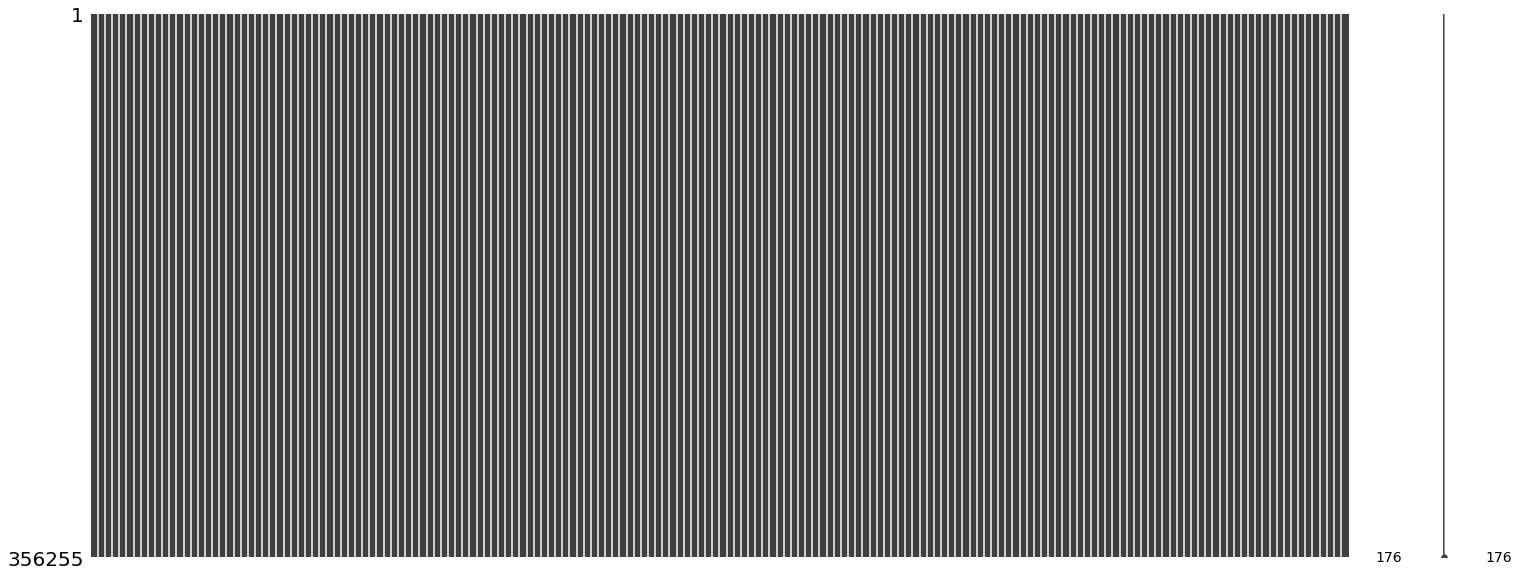

In [13]:
import missingno as msno
# Visualize missing values as a matrix
msno.matrix(df_train_test)

In [14]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows) # ??? num_rows
    bb =pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category) # bb  is the dataframe and bb_cat are the colums created of categorical values 
                                                    # (='STATUS' columns of bb) after one hot encoding
        
    
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category) # same here
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']} # Creat a dictionary 
    for col in bb_cat:
        bb_aggregations[col] = ['mean'] # 3 column names  of 'MONTHS_BALANCE' are created here : 'MONTHS_BALANCE' min
                                        #  'MONTHS_BALANCE' max, 'MONTHS_BALANCE' size
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations) # here we perform the calculation with agg methode for min, max and size columns of 'MONTHS_BALANCE
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]) # Change the multilevel index into one single column name
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU') # The 2 dataframes Bureau and burea balance are joined on 'SK_ID_BUREAU' which is the loan made by every client, many loans are possible for one client
    bureau.drop(columns= 'SK_ID_BUREAU', inplace= True) #" We no longer need the 'SK_ID_BUREAU' column"
    del bb, bb_agg # deleting the unnecessary data 
    gc.collect()  # collecting the garbage
    
    # Bureau and bureau_balance numeric features
    # This dictionary contains all the names of the numerical columns from the bureau dataframe and the aggregations that will be performed on each one of them 
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    # Constructing a dictionary for categorical columns for the bureau and bureau balance dataframes, 
    # that contains the names of the categorical columns along with the aggregations
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean'] # aggregations for categoricals columns of bureau dataframe that we obtained after one hot encoding
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']# aggreg for bb_cat the bureau_balance dataframe after one hot encoding
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations}) # We group by clients ID SK_ID_CURR = one row per client
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()]) # change the multi index naming to have one single name for every formed column
#     # Bureau: Active credits - using only numerical aggregations
#     active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1] # filter the data in bureau dataframe by selecting the active credit clients
#     active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations) # make the aggregations for numerical columns for all the active clients
#     active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()]) # from multi-indexing make one single name per column
#     bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR') # 
#     del active, active_agg
#     gc.collect()
#     # Bureau: Closed credits - using only numerical aggregations
#     closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
#     closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
#     closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
#     del closed, closed_agg, bureau
#     gc.collect()
    
    # Dealing with NaN values
    bureau_agg = data_empty_columns_dropper (bureau_agg) # We drop columns of filling rate inferior to 80%
    bureau_agg = detect_nulls_and_impute(bureau_agg)
    
#     empty_columns = bureau_agg.columns[bureau_agg.isnull().any()] # Define the columns that still have missing values
#     for col in empty_columns: # Impute these columns with the mean value 
#         bureau_agg[col].fillna(bureau_agg[col].mean(), inplace = True)
       

    return bureau_agg


In [15]:
bureau_agg = bureau_and_balance()

<AxesSubplot:>

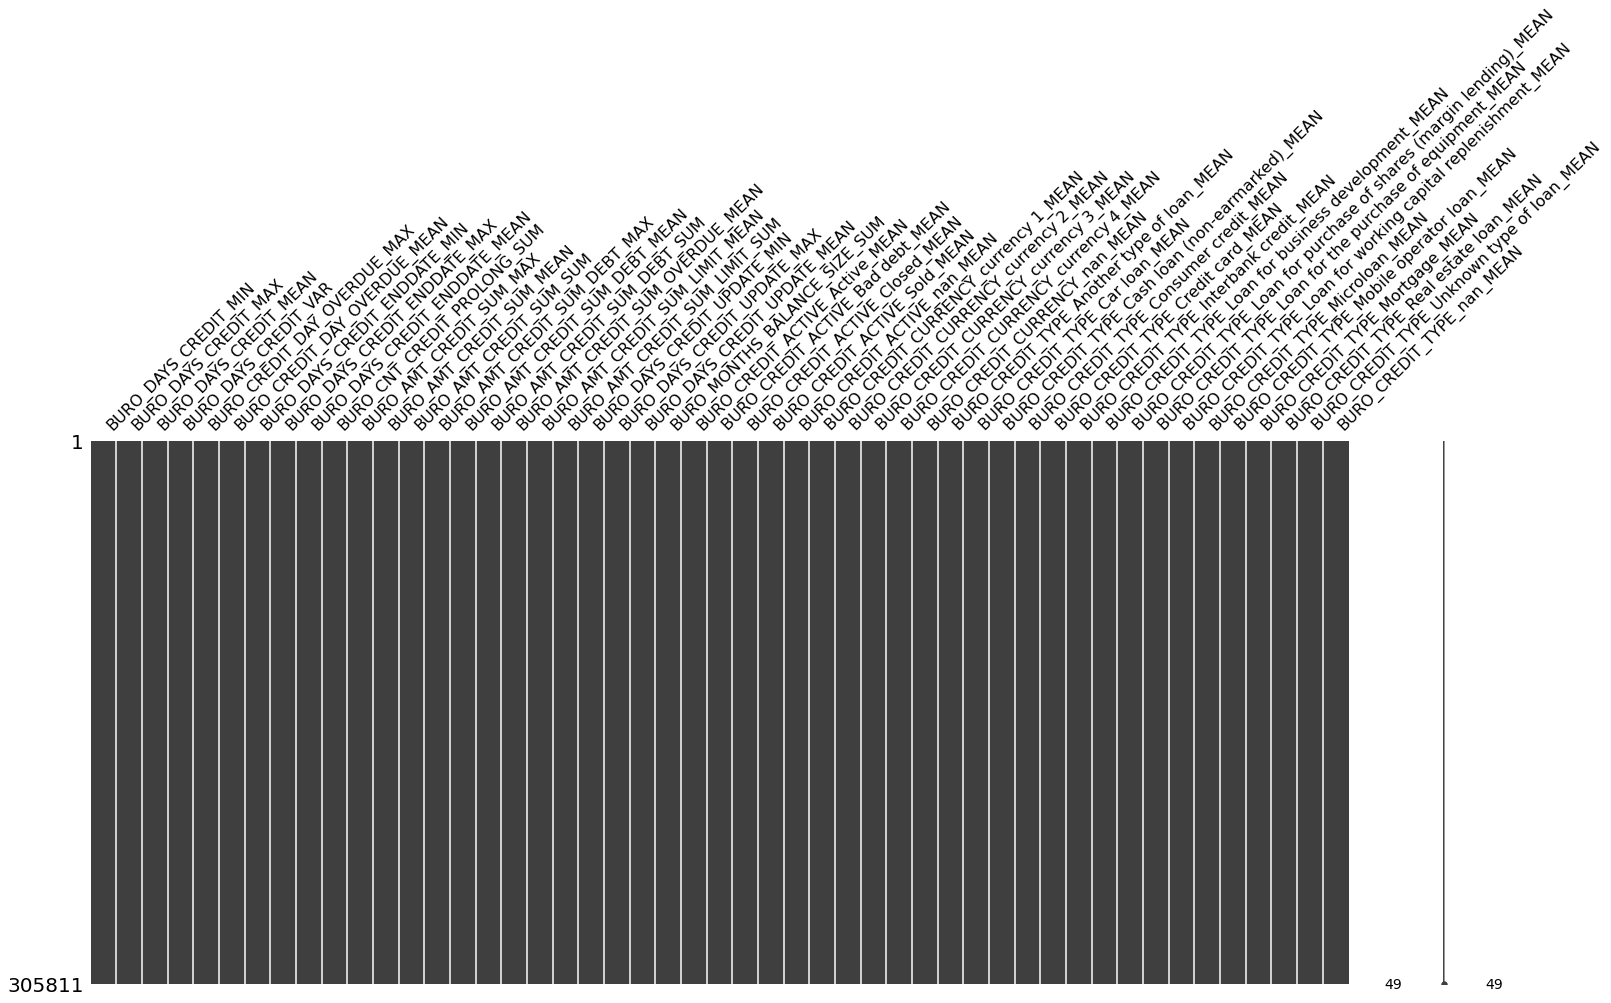

In [16]:
import missingno as msno
# Visualize missing values as a matrix
msno.matrix(bureau_agg)

In [17]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    
   
 # Days 365.243 values -> nan
#     prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
   
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
   
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    prev_agg = data_empty_columns_dropper(prev_agg) # dropping columns with at least 20% empty values
    prev_agg = detect_nulls_and_impute(prev_agg) # imputing the rest of the empty values with the modal values
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [18]:
prev_agg = previous_applications()

<AxesSubplot:>

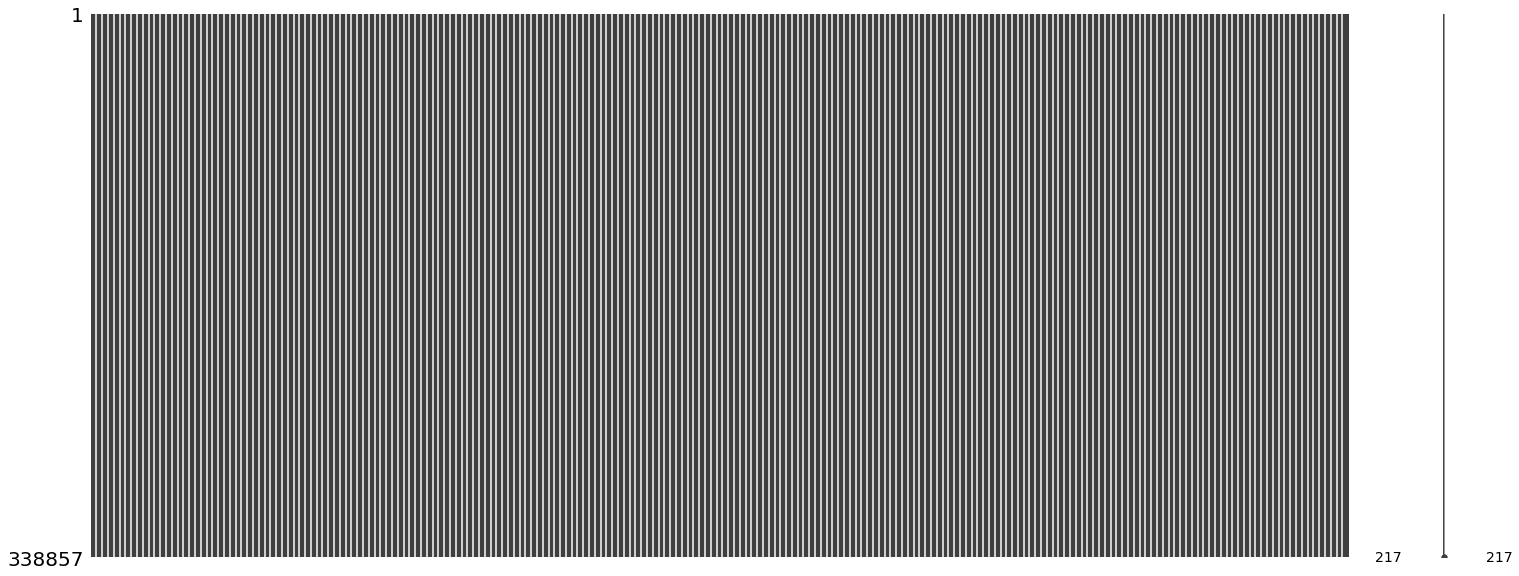

In [19]:
import missingno as msno
# Visualize missing values as a matrix
msno.matrix(prev_agg)

In [20]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    pos_agg = data_empty_columns_dropper(pos_agg) # dropping columns with at least 20% empty values
    pos_agg = detect_nulls_and_impute(pos_agg) # imputing the rest of the empty values with the modal values
    del pos
    gc.collect()
    return pos_agg

In [21]:
pos_agg = pos_cash()

<AxesSubplot:>

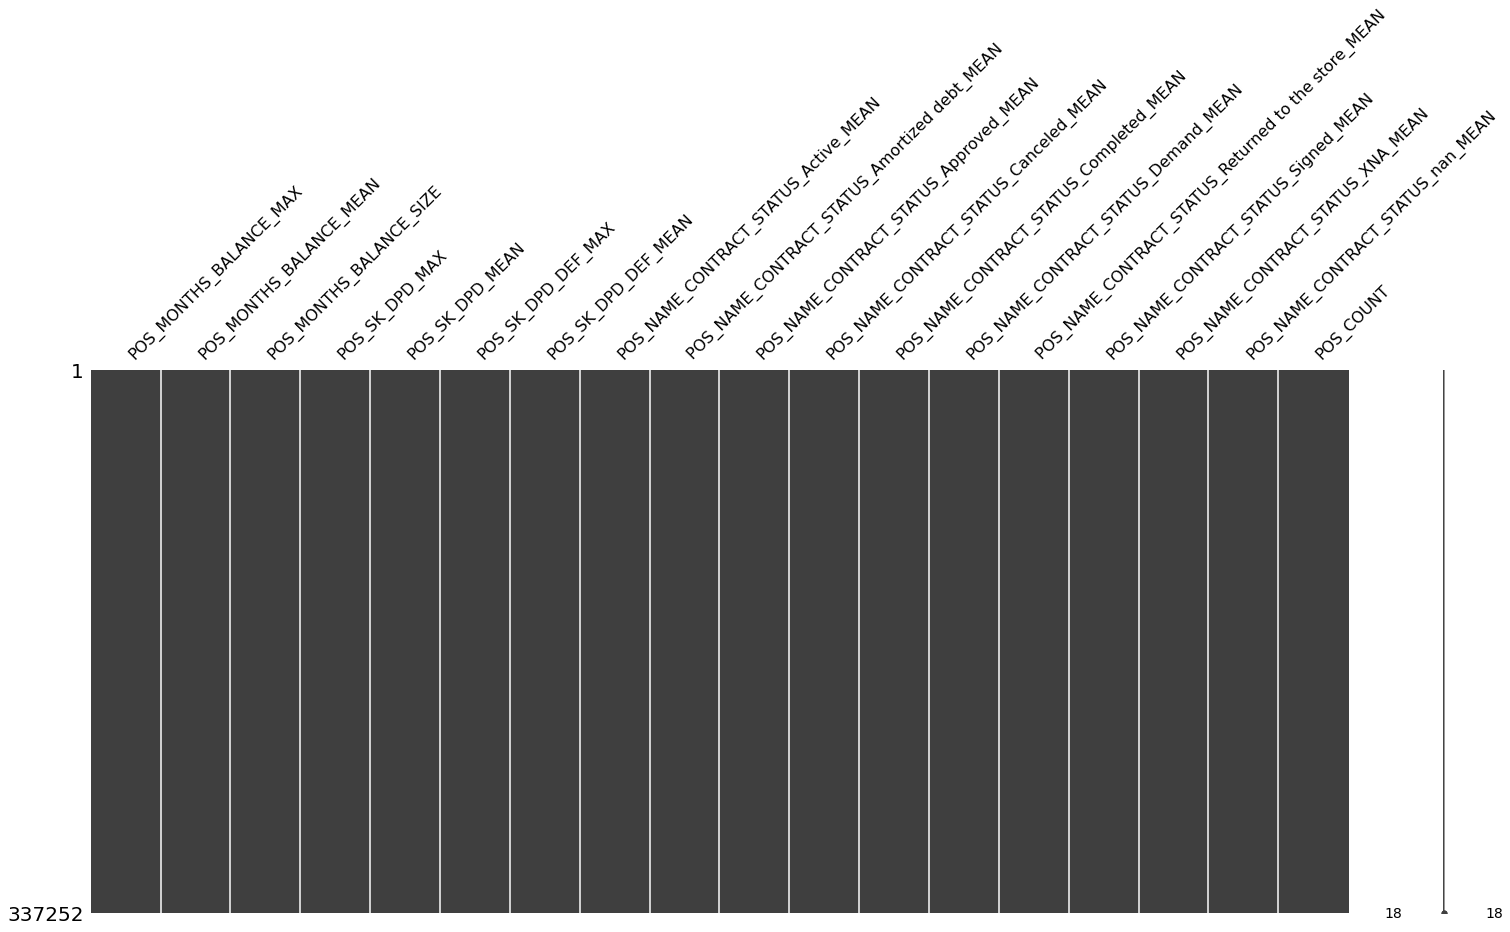

In [22]:
msno.matrix(pos_agg)

In [23]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    ins_agg = data_empty_columns_dropper(ins_agg) # dropping columns with at least 20% empty values
    ins_agg = detect_nulls_and_impute(ins_agg) # imputing the rest of the empty values with the modal values
    del ins
    gc.collect()
    return ins_agg

In [24]:
ins_agg = installments_payments()

<AxesSubplot:>

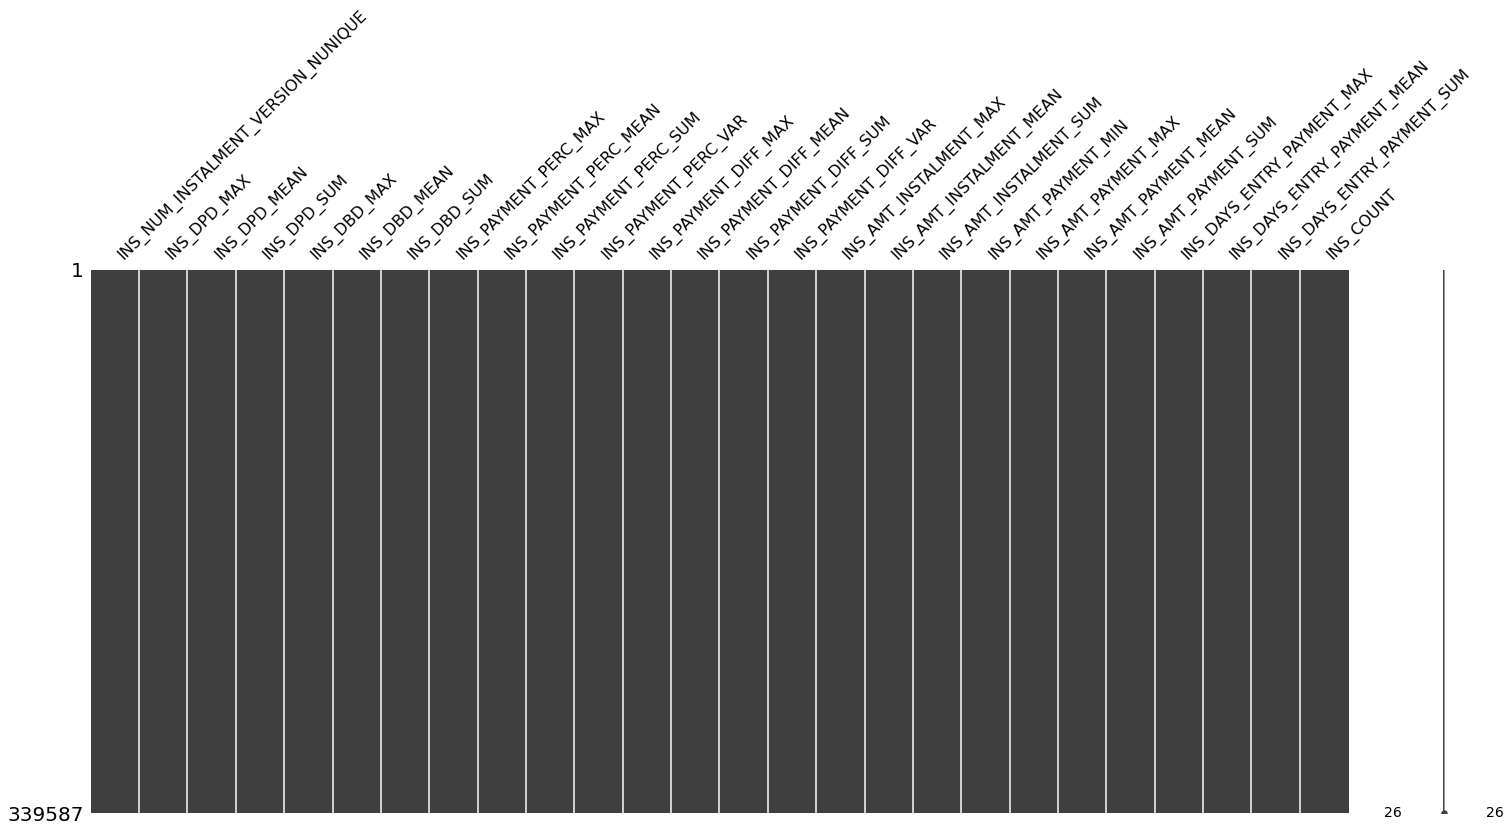

In [25]:
msno.matrix(ins_agg)

In [26]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(columns = ['SK_ID_PREV'], inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    cc_agg = data_empty_columns_dropper(cc_agg) # dropping columns with at least 20% empty values
    cc_agg = detect_nulls_and_impute(cc_agg) # imputing the rest of the empty values with the modal values
    del cc
    gc.collect()
    return cc_agg

In [27]:
cc_agg = credit_card_balance()

<AxesSubplot:>

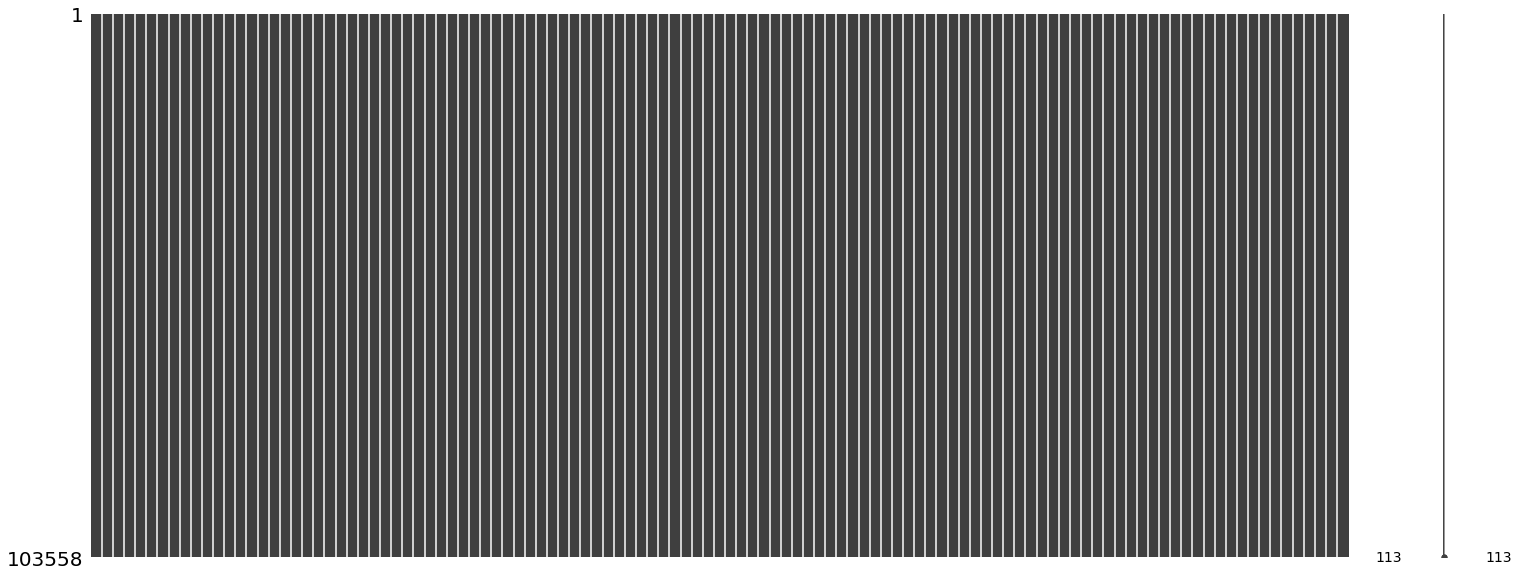

In [28]:
msno.matrix(cc_agg)

In [29]:
# Merging the datasets together
df = pd.merge(df_train_test,bureau_agg, how='left', on='SK_ID_CURR')
df = pd.merge(df,prev_agg, how='left', on='SK_ID_CURR')
df = pd.merge(df,pos_agg, how='left', on='SK_ID_CURR')
df = pd.merge(df,ins_agg, how='left', on='SK_ID_CURR')
#df = pd.merge(df,cc_agg, how='left', on='SK_ID_CURR')



<AxesSubplot:>

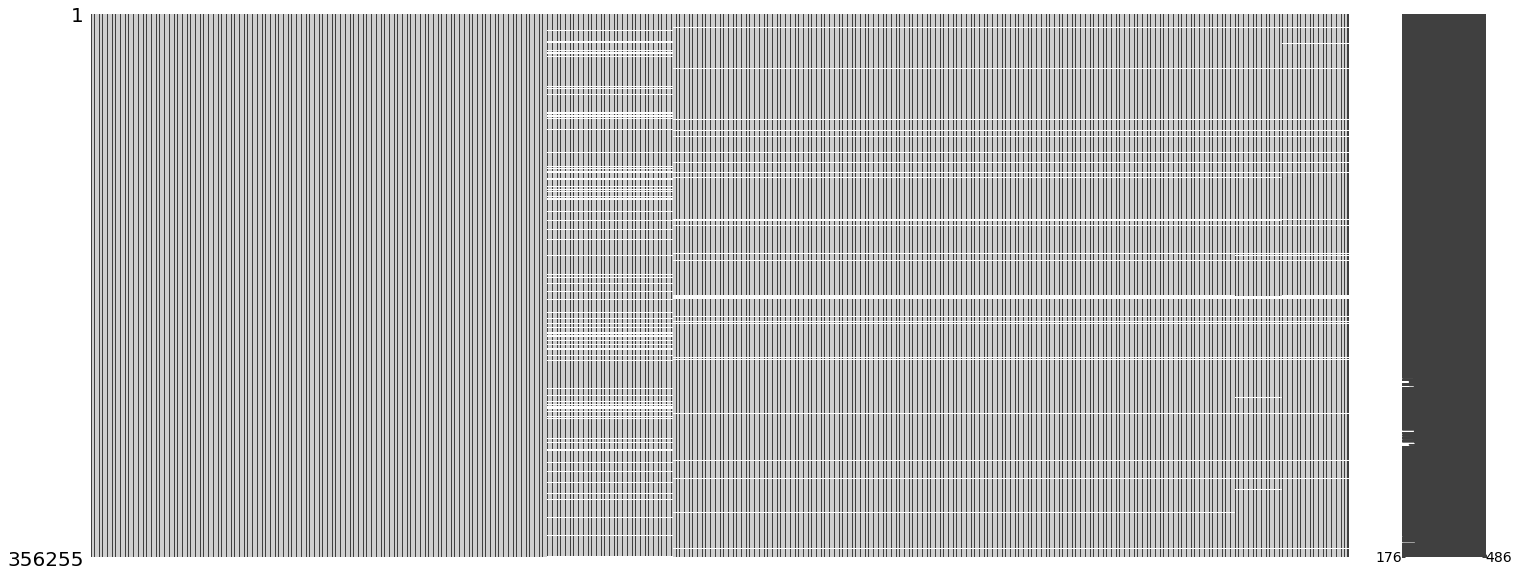

In [30]:
msno.matrix(df)

In [31]:
# Droping th eempty columns with at most 20% missing values
df = data_empty_columns_dropper(df) 


In [32]:
# Dealing with the rest of the missing values by modal imputation
df_final = detect_nulls_and_impute(df) 

KeyboardInterrupt: 

In [8]:
# Saving the final processed data
df_final.to_csv('./df_final.csv', index=False)

In [33]:
df_final = pd.read_csv('df_final.csv')

In [34]:
df_final.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'INS_AMT_INSTALMENT_MEAN', 'INS_AMT_INSTALMENT_SUM',
       'INS_AMT_PAYMENT_MIN', 'INS_AMT_PAYMENT_MAX', 'INS_AMT_PAYMENT_MEAN',
       'INS_AMT_PAYMENT_SUM', 'INS_DAYS_ENTRY_PAYMENT_MAX',
       'INS_DAYS_ENTRY_PAYMENT_MEAN', 'INS_DAYS_ENTRY_PAYMENT_SUM',
       'INS_COUNT'],
      dtype='object', length=485)

In [35]:
#df_final=df_final.drop(['Unnamed: 0', 'index'], axis=1)

In [36]:
df_final.shape

(356255, 485)

In [37]:
df_final.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employ

### We have so far preprocessed all the datasets and merged them together , we ended up with a dataframe of shape (356255, 486).
### Next we will try to reduce the number of features and therefore improve the efficiency and effectiveness of  our predictive model.
### To do so we will try to calculate the relative importance of each feature when making a prediction - Feature importance.


## Dealing with imbalanced data

In [38]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.1.1


In [39]:
df_final['TARGET'].value_counts()

0.0    331430
1.0     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

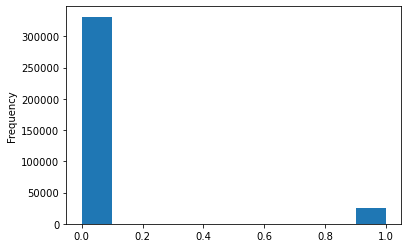

In [40]:
# We see that we have an imbalanced data so we will have to deal with it  before training any model on the data
df_final['TARGET'].astype(int).plot.hist()

In [41]:
# pip install -U imbalanced-learn

In [42]:
# pip install imblearn --user 


## Oversampling 
The Oversampling technique is quite helpful for handling the imbalanced dataset. This technique redistributes randomly the minority class data points to increase the ratio in the dataset. It duplicates the existing data points of minority class and equalizes the ratio of majority and minority class.

In [43]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The nltk version is 3.6.5.
The scikit-learn version is 1.1.1.


In [44]:
# Separate the depend variable ( 'target') and independent variables
X_dependent_features = df_final.loc[:, df_final.columns != 'TARGET']
Y_independet_feature = df_final['TARGET']

print(X_dependent_features.shape)
print(Y_independet_feature.shape)

# To balance the data we can use the following method
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, Y_res = ros.fit_resample(X_dependent_features, Y_independet_feature)


print(X_res.shape,Y_res.shape)

(356255, 484)
(356255,)
(662860, 484) (662860,)


In [45]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y_independet_feature)))
print('Resampled dataset shape {}'.format(Counter(Y_res)))

Original dataset shape Counter({0.0: 331430, 1.0: 24825})
Resampled dataset shape Counter({1.0: 331430, 0.0: 331430})


In [46]:
# final_data_res = X_res.copy()
# final_data_res['TARGET'] = Y_res
# loan_repaid= final_data_res[final_data_res['TARGET']==1]

# loan_nont_repaid = final_data_res[final_data_res['TARGET']==0]

<AxesSubplot:ylabel='Frequency'>

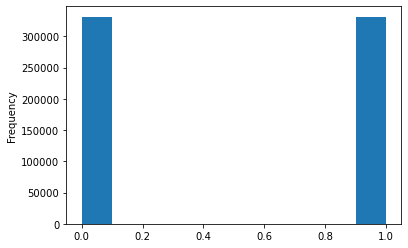

In [69]:
# Making a new dataset with balanced categories
final_data_res = X_res.copy()
final_data_res['TARGET'] = Y_res

# Visualizing after the balancing of the data we have as much data on repaid loans (1) as non repaid loans(0)
final_data_res['TARGET'].astype(int).plot.hist()

In [70]:
final_data_res.isnull().sum()

SK_ID_CURR                                                               0
CODE_GENDER                                                              0
FLAG_OWN_CAR                                                             0
FLAG_OWN_REALTY                                                          0
CNT_CHILDREN                                                             0
AMT_INCOME_TOTAL                                                         0
AMT_CREDIT                                                               0
AMT_ANNUITY                                                              0
AMT_GOODS_PRICE                                                          0
REGION_POPULATION_RELATIVE                                               0
DAYS_BIRTH                                                               0
DAYS_EMPLOYED                                                            0
DAYS_REGISTRATION                                                        0
DAYS_ID_PUBLISH          

In [71]:
final_data_res.shape

(662860, 485)

In [50]:
# Feature importance calculating 
# Shuffle and split data into training and testing 
# apply a model ( Classification model - we are trying to predict the class to which our input value is more likely to be part of
                    # the performance of those models should be measured as an accuracy to predict correct values, logistic regression is a classification model
                # is a regression model the predicted value is a quantity like a houses price
                # the performance of a model should be meaured by an error in thouse predictions, linear regression is regression model
            # Some algorithms have the word “regression” in their name, such as linear regression and logistic regression, which can make
            # things confusing because linear regression is a regression algorithm whereas logistic regression is a classification algorithm.Classification vs Regression)
# 

In [72]:
# Verifying if there is infinite values in the dataframe because the below code for feature importance showed error message 
np.any(np.isinf(final_data_res)) # here we see that there is infinite values

True

In [73]:
# Getting the indexes of the infinite values in the datframe 
infinity = final_data_res.iloc[final_data_res.values==np.inf] 
infinity_values_indexes = list(infinity.index.values) 

# Dropping the infiite value indexes ( the rows with infinte values)
infity_free_data = final_data_res.drop(infinity_values_indexes) # the X ( independent features)
infinity_indexes_free_targets = final_data_res['TARGET'].drop(infinity_values_indexes) # the Y ( target variable)

In [74]:
infinity_values_indexes = list(infinity.index.values)

In [75]:
from sklearn.preprocessing import StandardScaler

data = infity_free_data.to_numpy()
scaler = StandardScaler()

fitted_data = scaler.fit(data)
scaled_data = scaler.transform(data)

In [76]:
df = pd.DataFrame(scaled_data, columns = infity_free_data.columns)

In [57]:
#df.to_csv('./df.csv', index= False)

In [59]:
df = pd.read_csv('./df.csv')

In [60]:
df['SK_ID_CURR'].nunique()

327540

In [77]:
# Shuffle the data before splitting it into half
shuffled = df.sample(frac=1)
df_balanced= shuffled.iloc[0:356234]

In [78]:
df_balanced.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGA

In [79]:
df_balanced.shape

(356234, 485)

<AxesSubplot:ylabel='Frequency'>

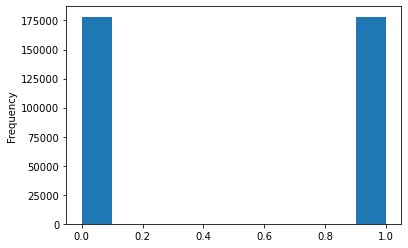

In [80]:
# We see that we have an imbalanced data so we will have to deal with it  before training any model on the data
df_balanced['TARGET'].astype(int).plot.hist()

In [81]:
# Save the data
df_balanced.to_csv('./df_balanced.csv', index = False)

In [70]:
df_balanced = pd.read_csv('df_balanced.csv')

In [82]:
X_dependent_feats = df_balanced.loc[:, df_balanced.columns != 'TARGET']
Y_independet_feat = df_balanced['TARGET'].astype(int)

In [83]:
from collections import Counter
print(' df_balanced dataset shape {}'.format(Counter(Y_independet_feat)))


 df_balanced dataset shape Counter({1: 178241, 0: 177993})


## The dataframe is too large to be handeled , we will be using only the half of it for memory saving purposes
### Let's first split the data into train and test sets

In [85]:
X = df_balanced.drop(['TARGET'], axis=1).iloc[0:100000]
y = Y_independet_feat.iloc[0:100000]

### Feature selection - dropping constant features

In [101]:
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold()
var_thres.fit(X)


VarianceThreshold()

In [102]:
# Lets Find non-constant features 
len(X.columns[var_thres.get_support()])

452

In [105]:
# defining the contant columns
constant_columns = [column for column in X.columns
                    if column not in X.columns[var_thres.get_support()]]

print(len(constant_columns))

32


In [106]:
constant_columns

['FLAG_DOCUMENT_12',
 'NAME_CONTRACT_TYPE_nan',
 'NAME_TYPE_SUITE_nan',
 'NAME_INCOME_TYPE_nan',
 'NAME_EDUCATION_TYPE_nan',
 'NAME_FAMILY_STATUS_Unknown',
 'NAME_FAMILY_STATUS_nan',
 'NAME_HOUSING_TYPE_nan',
 'WEEKDAY_APPR_PROCESS_START_nan',
 'ORGANIZATION_TYPE_nan',
 'BURO_CREDIT_ACTIVE_nan_MEAN',
 'BURO_CREDIT_CURRENCY_nan_MEAN',
 'BURO_CREDIT_TYPE_Interbank credit_MEAN',
 'BURO_CREDIT_TYPE_nan_MEAN',
 'PREV_NAME_CONTRACT_TYPE_nan_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN',
 'PREV_NAME_CONTRACT_STATUS_nan_MEAN',
 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
 'PREV_CODE_REJECT_REASON_nan_MEAN',
 'PREV_NAME_CLIENT_TYPE_nan_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
 'PREV_NAME_PORTFOLIO_nan_MEAN',
 'PREV_NAME_PRODUCT_TYPE_nan_MEAN',
 'PREV_CHANNEL_TYPE_nan_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN',
 'P

In [92]:
## See which columns are constant columns
# for column in constant_columns:
#     print(column)

In [107]:
# Dropppingthe contant columns from the dataframe
X= X.drop(constant_columns,axis=1)


In [108]:
print(X.shape)

(100000, 452)


 ## Feature Selection

### Feature Selection base on Correlation

In [109]:

# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [110]:
corr_features = correlation(X, 0.7)
len(set(corr_features))

119

In [111]:
X = X.drop(corr_features,axis=1)

print(X.shape)



(100000, 333)


In [99]:
# # Représentation en heatmap des corrélations linéaires entre les features de la dataframe = data finale après séléction de meilleurs features
# matrix = X_train.corr().abs()

# # Create a mask
# plt.figure(figsize=(16,12))

# # Create a custom diverging palette
# cmap = sns.diverging_palette(250, 15, s=75, l=40,
#                              n=9, center="light", as_cmap=True)
# mask = np.triu(np.ones_like(matrix, dtype=bool))

# _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
#              fmt='.2f', square=True, cmap=cmap)


# reduced_matrix = matrix.mask(mask)

# # # This list comprehension finds all other columns that meet the threshold of 0.7. 
# # to_drop3 = [c for c in reduced_matrix3.columns if any(reduced_matrix3[c] > 0.7)]

### Feature Selection-Information gain - mutual information In Classification Problem 
 - mutual information measures the amount of information one can obtain from one random variable given another
 - (X ; Y) = H(X) – H(X | Y) Where I(X ; Y) is the mutual information for X and Y, H(X) is the entropy for X and H(X | Y) is the conditional entropy for X given Y. The result has the units of bits.

In [112]:
from sklearn.feature_selection import mutual_info_classif
# Calculate the mutual information
mutual_info = mutual_info_classif(X, y)

In [113]:
# Get the columns for which the dependecy to the target values is equal to 0
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
#_mutual_info_values = mutual_info.sort_values(ascending=False)

dataframe_mutual_info = pd.DataFrame(mutual_info)
zero_dependent_cols = dataframe_mutual_info.index[dataframe_mutual_info[0] == 0.000000].tolist()


In [114]:
X = X.drop(zero_dependent_cols, axis=1)

 ## Feature Selection base on variance

In [115]:
# Variance after MinMaxScaling (without outlier Zscore > 5)

import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

thresh = 6
minmax = MinMaxScaler()

tab_ = []
for col in X.columns:
    ser_ = X[col]
    mask_outl = np.abs(st.zscore(ser_))<thresh
    ser_ = minmax.fit_transform(ser_.loc[mask_outl].to_frame()).reshape(-1)
    tab_.append(ser_.var(axis=0)*100) # relative variance (pct)
    
rel_var_df = pd.Series(tab_,
                       index=X.columns).to_frame(name='rel_var_pct')
    
display(rel_var_df.sort_values('rel_var_pct'))

,rel_var_pct
BURO_CREDIT_CURRENCY_currency 4_MEAN,0.000000
ORGANIZATION_TYPE_Industry: type 7,0.000000
ORGANIZATION_TYPE_Industry: type 3,0.000000
ORGANIZATION_TYPE_Industry: type 13,0.000000
ORGANIZATION_TYPE_Industry: type 1,0.000000
ORGANIZATION_TYPE_Housing,0.000000
ORGANIZATION_TYPE_Emergency,0.000000
ORGANIZATION_TYPE_Construction,0.000000
ORGANIZATION_TYPE_Business Entity Type 1,0.000000
ORGANIZATION_TYPE_Industry: type 9,0.000000


In [116]:
low_var_cols = rel_var_df[rel_var_df['rel_var_pct']<0.006].index
low_var_cols

Index(['FLAG_MOBIL', 'REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'NAME_TYPE_SUITE_Group of people',
       'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B',
       'NAME_INCOME_TYPE_Unemployed', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'ORGANIZATION_TYPE_Advertising',
       'ORGANIZATION_TYPE_Agriculture', 'ORGANIZATION_TYPE_Bank',
       'ORGANIZATION_TYPE_Business Entity Type 1',
       'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Electricity',
       'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Housi

In [117]:
len(low_var_cols)

64

In [118]:
X = X.drop(low_var_cols, axis=1)

In [119]:
print(X.shape)

(100000, 213)


In [120]:
X.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_TYPE_SUITE_Family,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ANNUITY_INCOME_PERC,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_DAYS_CREDIT_UPDATE_MIN,BURO_DAYS_CREDIT_UPDATE_MAX,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_APPLICATION_MIN,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Repairs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Urgent needs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,PREV_NAME

### feature selection based on Variance inflation factor


In [121]:
### Feature selection based on colinearity (Variance Inflation Factor)
# Variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms
# by the variance of a model with one term alone. It quantifies the severity of multicollinearity.
# Let's compute the values of VIF for our quantitative features:

from statsmodels.stats.outliers_influence import variance_inflation_factor    

variables = X.columns
var_inflation = pd.Series([variance_inflation_factor(X.loc[:, variables].values, ix)\
               for ix in range(len(variables))], index = variables).to_frame(name='variance_inflation')
var_inflation = var_inflation.sort_values('variance_inflation')

display(var_inflation.sort_values('variance_inflation'))

C:\Users\adele\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variance_inflation
SK_ID_CURR,1.003759e+00
INS_PAYMENT_PERC_MAX,1.004271e+00
PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN,1.009803e+00
PREV_NAME_CLIENT_TYPE_XNA_MEAN,1.010754e+00
AMT_REQ_CREDIT_BUREAU_WEEK,1.011437e+00
AMT_INCOME_TOTAL,1.014123e+00
PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN,1.019456e+00
BURO_CREDIT_TYPE_Loan for business development_MEAN,1.023453e+00
PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,1.025236e+00
PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,1.028645e+00


In [134]:
high_var_inf_cols = var_inflation[var_inflation['variance_inflation']>5].index
high_var_inf_cols

Index(['PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN',
       'PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN',
       'BURO_DAYS_CREDIT_MIN',
       'PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN',
       'PREV_APP_CREDIT_PERC_MIN', 'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 'FLAG_DOCUMENT_3',
       'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN',
       'PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN',
       'PREV_APP_CREDIT_PERC_MEAN',
       'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN',
       'BURO_DAYS_CREDIT_MAX',
       'PREV_PRODUCT_COMBINATION_Cash Street: middle_MEAN',
       'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN', 'PREV_CHANNEL_TYPE_Stone_MEAN',
       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN',
       'PREV_CHANNEL_TYPE_Country-wide_MEAN', 'BURO_DAYS_CREDIT_MEAN',
       'PREV_NAME_TYPE_SUITE_Family_MEAN',
       'PREV_NAME_GOODS_CATEGORY_Furniture_MEAN',
       'PREV_PRODUCT_COM

In [124]:
X = X.drop(high_var_inf_cols, axis=1)

print(X.shape)

(100000, 155)


### Features selection : SelectKbest (mutual information or ANOVA f1 based)

In [125]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

best_features = pd.DataFrame()

# compute mutual information score of each feature
mutual_info_scores = mutual_info_classif(X[X.columns].values, y.values)
ser = pd.Series(mutual_info_scores,
                index=X.columns).to_frame(name='mutual_info_classif')
best_features = pd.concat([best_features, ser*10000])

# compute ANOVA f1 score of each feature
f_scores, _ = f_classif(X[X.columns].values, y.values)
ser = pd.Series(f_scores,
                index=X.columns).to_frame(name='f_classif')
best_features = pd.concat([best_features, ser], axis=1)

In [126]:
display(best_features.sort_values('mutual_info_classif'))

,mutual_info_classif,f_classif
REG_REGION_NOT_WORK_REGION,0.000000,8.973618
ORGANIZATION_TYPE_Government,0.000000,27.517850
ORGANIZATION_TYPE_Other,0.000000,7.554425
BURO_CNT_CREDIT_PROLONG_SUM,0.000000,7.683764
PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN,0.000000,6.743664
PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,0.000000,0.596567
PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN,0.000000,16.415291
PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN,0.000000,2.907575
PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN,0.000000,4.555726
NAME_EDUCATION_TYPE_Incomplete higher,0.000000,3.133963


In [127]:
factor = 50
# boolean masks to select features to be dropped
cond1 = best_features['mutual_info_classif']<best_features['mutual_info_classif'].std()/factor
cond2 = best_features['f_classif']<best_features['f_classif'].std()/factor
worst_feat = best_features.loc[cond1&cond2]
worst_feat

,mutual_info_classif,f_classif
REG_REGION_NOT_WORK_REGION,0.000000,8.973618
NAME_EDUCATION_TYPE_Incomplete higher,0.000000,3.133963
ORGANIZATION_TYPE_Other,0.000000,7.554425
BURO_CNT_CREDIT_PROLONG_SUM,0.000000,7.683764
BURO_CREDIT_TYPE_Loan for business development_MEAN,3.708272,3.445160
PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN,0.000000,6.743664
PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,0.000000,0.596567
PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN,1.315052,0.730502
PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN,0.000000,2.907575
PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN,0.000000,4.555726


In [128]:
worst_feat.index

Index(['REG_REGION_NOT_WORK_REGION', 'NAME_EDUCATION_TYPE_Incomplete higher',
       'ORGANIZATION_TYPE_Other', 'BURO_CNT_CREDIT_PROLONG_SUM',
       'BURO_CREDIT_TYPE_Loan for business development_MEAN',
       'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN',
       'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN',
       'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN',
       'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN',
       'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN',
       'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN',
       'PREV_NAME_GOODS_CATEGORY_Other_MEAN',
       'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN'],
      dtype='object')

In [129]:
# drop features with low scores
X = X.drop(worst_feat.index, axis=1)

In [130]:
print(X.shape)


(100000, 142)


## feature selection based on  Permutation importance (model based)

In [79]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [131]:
# Changing the names of some features because of error:
#LightGBMError: Do not support special JSON characters in feature name.
# The check for special json characters .e.g [],{}": in features names and throw an error if found.
import re
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [132]:
sample_X = X.iloc[0:10000]
sample_y = y[0:10000]

In [133]:
import lightgbm
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

lgbm = LGBMClassifier()
lgbm.fit(sample_X, sample_y)
result_lgbm = permutation_importance(lgbm, sample_X, sample_y,
                                     n_repeats=10, random_state=14)

rf = RandomForestClassifier()
rf.fit(sample_X, sample_y)
result_rf = permutation_importance(rf, sample_X, sample_y,
                                   n_repeats=10, random_state=14)

df_permut_importance = pd.DataFrame({'LGBM': result_lgbm.importances_mean*1000,
                                   'RF': result_rf.importances_mean*1000},
                                  index=sample_X.columns)

In [135]:
# boolean masks to select features to be dropped
# find n less important features according to both models

n=25
less_perm_imp_feat = df_permut_importance
factors = np.logspace(0,4,30)#.astype('int')
cpt = 0
while less_perm_imp_feat.shape[0]>=n:
    print(cpt, less_perm_imp_feat.shape)
    # boolean masks to select features to be dropped
    try:
        
        cond1 = df_permut_importance['LGBM']<df_permut_importance['LGBM'].std()/factors[cpt]
        cond2 = df_permut_importance['RF']<df_permut_importance['RF'].std()/factors[cpt]
        less_perm_imp_feat = df_permut_importance.loc[cond1&cond2]
        cpt += 1
    except:
        break
        
less_perm_imp_feat

0 (142, 2)
1 (126, 2)
2 (111, 2)
3 (101, 2)
4 (91, 2)
5 (80, 2)
6 (77, 2)
7 (69, 2)
8 (64, 2)
9 (56, 2)
10 (52, 2)
11 (46, 2)
12 (42, 2)
13 (37, 2)
14 (35, 2)
15 (33, 2)
16 (29, 2)
17 (28, 2)
18 (28, 2)
19 (27, 2)
20 (26, 2)
21 (25, 2)
22 (25, 2)
23 (25, 2)
24 (25, 2)
25 (25, 2)
26 (25, 2)
27 (25, 2)
28 (25, 2)
29 (25, 2)
30 (25, 2)


,LGBM,RF
FLAG_DOCUMENT_8,-0.01,0.0
NAME_TYPE_SUITE_Spousepartner,0.00,0.0
ORGANIZATION_TYPE_BusinessEntityType3,-0.02,0.0
ORGANIZATION_TYPE_Government,0.00,0.0
ORGANIZATION_TYPE_Tradetype7,0.00,0.0
BURO_CREDIT_ACTIVE_Sold_MEAN,-0.09,0.0
BURO_CREDIT_CURRENCY_currency1_MEAN,0.00,0.0
PREV_NAME_CONTRACT_TYPE_XNA_MEAN,0.00,0.0
PREV_NAME_CASH_LOAN_PURPOSE_Buildingahouseoranannex_MEAN,-0.02,0.0
PREV_NAME_CASH_LOAN_PURPOSE_Buyingahome_MEAN,0.00,0.0


In [136]:
X.shape

(100000, 142)

In [137]:
X = X.drop(less_perm_imp_feat.index , axis =1)

In [138]:
X.shape

(100000, 117)

In [139]:
X.to_csv('./X.csv', index = False)
y.to_csv('./y.csv', index = False)

In [2]:
X = pd.read_csv('./X.csv')
y = pd.read_csv('./y.csv')


## Train test split

In [3]:
from sklearn.model_selection import train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

X_train.shape, X_test.shape

((70000, 117), (30000, 117))

In [47]:
y_train

,TARGET
42865,0
91446,1
66374,1
79106,0
13404,0
...,...
21243,1
45891,0
42613,1
43567,1


In [4]:
y_train= y_train['TARGET']

In [5]:
y_test = y_test['TARGET']

# Modeling with GridSearch

## Logistic Regression 
 Machine Learning classification algorithm that isused to predict the probability of a categorical dependent variable.

In [6]:

import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn import metrics

In [7]:
# Grid search cross validation

logreg_model=LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ["l1","l2"] # l1 lasso l2 ridge
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
logreg_cv =RandomizedSearchCV(estimator=logreg_model, param_distributions=grid, n_jobs=-1, cv=cv,
                           scoring= 'roc_auc',error_score=0)

grid_result = logreg_cv.fit(X_train, y_train)

KeyboardInterrupt: 

In [26]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.755850 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}


In [7]:
logreg_model=LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 0.1)

In [8]:
logreg = logreg_model.fit(X_train, y_train)

In [9]:
logreg_y_pred = logreg.predict(X_test)

In [34]:

test_score = grid_result.cv_results_['mean_test_score']
fit_time = grid_result.cv_results_['mean_fit_time']
params = grid_result.cv_results_['params']
for test_score, fit_time, param in zip(test_score, fit_time, params):
    print("%f (%f) with: %r" % (test_score, fit_time, param))

0.755846 (5.036228) with: {'solver': 'liblinear', 'penalty': 'l1', 'C': 100}
0.000000 (0.187940) with: {'solver': 'lbfgs', 'penalty': 'l1', 'C': 1.0}
0.755845 (11.071068) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}
0.755845 (10.829166) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}
0.755845 (2.333577) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}
0.755829 (6.658136) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}
0.755843 (10.478748) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}
0.755844 (2.307200) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}
0.000000 (0.178082) with: {'solver': 'lbfgs', 'penalty': 'l1', 'C': 10}
0.755850 (5.077908) with: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}


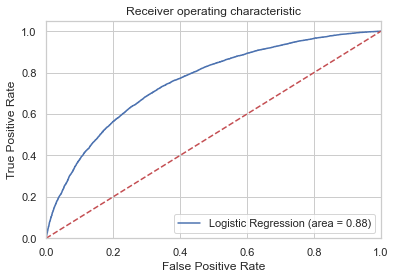

In [134]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc_lr = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

 ## XGBoost model 
 
 A gradient tree boosting-based method with some extensions.
 One of the extensions is the sparsity awareness that can handle the possibility of missing values.
 Therefore, XGBoost can process data with missing values without doing imputation first.

In [179]:

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# Grid search cross validation
XGBoost_model = XGBClassifier(use_label_encoder=False)

grid =params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
XGBoost_cv =RandomizedSearchCV(estimator=XGBoost_model, param_distributions=grid, n_jobs=-1, cv=cv,
                           scoring= 'roc_auc',error_score=0)

XGB_results = XGBoost_cv.fit(X_train, y_train)

In [53]:
print("Best: %f using %s" % (XGB_results.best_score_, XGB_results.best_params_))

Best: 0.808157 using {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.6}


In [180]:
xgb = XGBClassifier(subsample= 0.8, min_child_weight= 1, max_depth =5, gamma= 1, colsample_bytree= 0.6)

In [181]:
xgb_model = xgb.fit(X_train, y_train)

In [13]:
xgb_y_pred =xgb_model.predict(X_test)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, xgb_y_pred)
print(confusion_matrix)

[[10896  4105]
 [ 3860 11139]]


In [192]:
XGB_results.cv_results_

{'mean_fit_time': array([ 88.1210553 ,  41.76406992,  66.77189561, 101.76128615,
         54.65648299, 101.84789052,  82.07417537, 100.99168474,
         41.11819998,  50.27494579]),
 'std_fit_time': array([6.03075103, 1.50183562, 0.85095818, 1.07390565, 1.45994477,
        0.65618647, 0.40659655, 0.41396822, 0.10116801, 2.18893234]),
 'mean_score_time': array([0.1053136 , 0.10697403, 0.11439218, 0.11828822, 0.1124008 ,
        0.11888379, 0.11739775, 0.11679278, 0.10293585, 0.09800459]),
 'std_score_time': array([0.01004423, 0.01045183, 0.00647707, 0.00520292, 0.00316152,
        0.00405986, 0.00317833, 0.00277209, 0.00205005, 0.01177917]),
 'param_subsample': masked_array(data=[0.6, 0.8, 1.0, 0.6, 0.8, 0.6, 1.0, 0.6, 0.6, 0.6],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 10, 10, 10, 1, 5, 5, 1, 10, 1],
              ma

In [200]:

xgb_test_score = XGB_results.cv_results_['mean_test_score']
xgb_fit_time = XGB_results.cv_results_['mean_fit_time']
xgb_params = XGB_results.cv_results_['params']
for test_score, fit_time, param in zip(xgb_test_score, xgb_fit_time, xgb_params):
    print ("xgb_test_score is {}, xgb_fit_time is {}, xgb_params are {} ".format(test_score, fit_time, param))   


xgb_test_score is 0.8059828185859568, xgb_fit_time is 88.12105530103048, xgb_params are {'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 1.0} 
xgb_test_score is 0.7821062883008078, xgb_fit_time is 41.764069922765096, xgb_params are {'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 5, 'colsample_bytree': 0.6} 
xgb_test_score is 0.7935330098815759, xgb_fit_time is 66.77189560731252, xgb_params are {'subsample': 1.0, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8} 
xgb_test_score is 0.8009113317383622, xgb_fit_time is 101.76128614743551, xgb_params are {'subsample': 0.6, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 5, 'colsample_bytree': 1.0} 
xgb_test_score is 0.7934591357343889, xgb_fit_time is 54.65648299058278, xgb_params are {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 0.6} 
xgb_test_score is 0.8032366004631991, xgb_fit_time is 101.84789052009

In [183]:
xgb_test_score

array([0.80598282, 0.78210629, 0.79353301, 0.80091133, 0.79345914,
       0.8032366 , 0.80724414, 0.80633085, 0.78047604, 0.78138323])

In [184]:
xgb_fit_time

array([ 88.1210553 ,  41.76406992,  66.77189561, 101.76128615,
        54.65648299, 101.84789052,  82.07417537, 100.99168474,
        41.11819998,  50.27494579])

In [185]:
xgb_params

[{'subsample': 0.6,
  'min_child_weight': 1,
  'max_depth': 5,
  'gamma': 1.5,
  'colsample_bytree': 1.0},
 {'subsample': 0.8,
  'min_child_weight': 10,
  'max_depth': 3,
  'gamma': 5,
  'colsample_bytree': 0.6},
 {'subsample': 1.0,
  'min_child_weight': 10,
  'max_depth': 4,
  'gamma': 0.5,
  'colsample_bytree': 0.8},
 {'subsample': 0.6,
  'min_child_weight': 10,
  'max_depth': 5,
  'gamma': 5,
  'colsample_bytree': 1.0},
 {'subsample': 0.8,
  'min_child_weight': 1,
  'max_depth': 4,
  'gamma': 1.5,
  'colsample_bytree': 0.6},
 {'subsample': 0.6,
  'min_child_weight': 5,
  'max_depth': 5,
  'gamma': 0.5,
  'colsample_bytree': 1.0},
 {'subsample': 1.0,
  'min_child_weight': 5,
  'max_depth': 5,
  'gamma': 0.5,
  'colsample_bytree': 0.8},
 {'subsample': 0.6,
  'min_child_weight': 1,
  'max_depth': 5,
  'gamma': 2,
  'colsample_bytree': 1.0},
 {'subsample': 0.6,
  'min_child_weight': 10,
  'max_depth': 3,
  'gamma': 1.5,
  'colsample_bytree': 0.6},
 {'subsample': 0.6,
  'min_child_weight

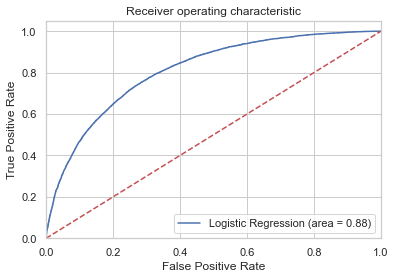

In [133]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

A confusion matrix shows the combination of the actual and predicted classes. Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class. 

### Random Forest model

In [21]:

from sklearn.ensemble import RandomForestClassifier
# Number of trees in random forest
n_estimators = [100, 500, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [50, 100, 115]
scoring = ['roc_auc']
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               
               #'bootstrap': bootstrap,
               'criterion': criterion}

In [22]:
from sklearn.model_selection import RandomizedSearchCV
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               random_state=42)


In [ ]:
#random_forest_model  = rf_random.fit(X_train, y_train)

In [ ]:

rf_test_score = rf_random.cv_results_['mean_test_score']
rf_fit_time = rf_random.cv_results_['mean_fit_time']
rf_params = rf_random.cv_results_['params']
for test_score, fit_time, param in zip(rf_test_score, rf_fit_time, rf_params):
    print("%f (%f) with: %r" % (rf_test_score, rf_fit_time, rf_param))

In [ ]:
#print("Best: %f using %s" % (XGB_results.best_score_, XGB_results.best_params_))

In [ ]:
random_forest = RandomForestClassifier( n_estimators =1000, max_features = 'auto',max_depth = 100, criterion = 'gini')

In [ ]:
random_forest_model =random_forest.fit(X_train, y_train)

In [ ]:
#metrics.confusion_matrix(y_test, preds)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The random forest model was trained on google collab, we have dowloaded the AUC scores for compararison.
This model performances are poor even after hyperpameter tuning. 

In [314]:
# Y_preds are imported from googl colab
random_forest_AUc_scores =pd.read_csv('Rando_forest_AUC_scores.csv')

In [316]:
type(random_forest_AUc_scores)

pandas.core.frame.DataFrame

In [317]:
# adding one value because instead of 30000 the shape is 2999
random_forest_AUc_scores.loc[len(random_forest_AUc_scores.index)] = [1.0]

In [318]:
random_forest_AUc_scores.shape

(30000, 1)

In [ ]:
# Converting to series
random_forest_y_preds = random_forest_AUc_scores['1.000000000000000000e+00']

In [ ]:
# Calculating ROC scores
logit_roc_auc_rand_for = roc_auc_score(y_test, random_forest_y_preds)

## SVM model

In [15]:
from sklearn.svm import SVC
model = SVC()

In [21]:
svc_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [23]:
from sklearn.model_selection import RandomizedSearchCV
grid = RandomizedSearchCV(model, svc_grid, refit = True, verbose = 3)

In [ ]:
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.693 total time=10.9min
[CV 2/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.689 total time=10.8min
[CV 3/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.693 total time=10.6min
[CV 4/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.690 total time=10.9min
[CV 5/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.692 total time=11.0min
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.839 total time=49.1min
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.840 total time=53.9min
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.842 total time=50.7min
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.836 total time=54.7min
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.835 total time=55.7min
[CV 1/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.698 total time=14.6min
[CV 2/5] END ...C=100, gamma=0.0001, kernel=rbf;

 #### C parameter deals with outliers:
An SVM will find the line or hyperplane that splits the data with the largest margin possible.
Though there will be outliers that sway the line in a certain direction, a C value that is small enough will enforce regularization throughout.

#### kernel : 
Polynomial features tend to be computationally expensive, and may increase runtime with large datasets. Instead of adding more polynomial features, it's better to add landmarks to test the proximity of other datapoints against.  Each member of the training set can be considered a landmark, and a kernel is the similarity function that measures how close an input is to said landmarks.



In [47]:
model = SVC(C = 1, gamma = 1, kernel='rbf', probability=True)

In [48]:
model_svc = model.fit(X_train, y_train)

In [56]:
svc_y_pred = model_svc.predict(X_test)

In [333]:
# Saving predictions
joblib.dump(svc_y_pred, 'svc_y_pred_joblib')

['svc_y_pred_joblib']

In [334]:
#load predictions
#svc_y_preds_joblib = joblib.load('svc_y_pred_joblib')

In [46]:
 model_svc.predict_proba(X_test.head(1))

AttributeError: predict_proba is not available when  probability=False

In [45]:
model_svc.predict(X_test.head(4))

array([1, 1, 0, 0], dtype=int64)

In [24]:
#best_params_svc = [C:1, gamma:1, kernel:rbf]

In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix_svc = confusion_matrix(y_test, svc_y_pred)
print(confusion_matrix_svc)

[[15001     0]
 [ 3607 11392]]


In [89]:
confusion_matrix_svc[1][0]

3607

In [30]:
!pip install  joblib

In [50]:
import joblib

In [51]:
from joblib import dump, load

In [53]:
joblib.dump(model_svc, 'model_svc_joblib')

['model_svc_joblib']

In [54]:
svc_joblib_model = joblib.load('model_svc_joblib')

In [55]:
svc_joblib_model.predict(X_test.head(4))

array([1, 1, 0, 0], dtype=int64)

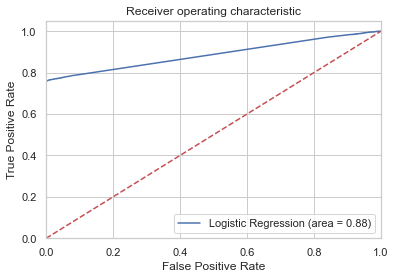

In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, svc_y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model_svc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [132]:
logit_roc_auc

0.8797586505767051

In [418]:

import matplotlib.pyplot as plt 
plt.rc("font", size=30)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn import metrics

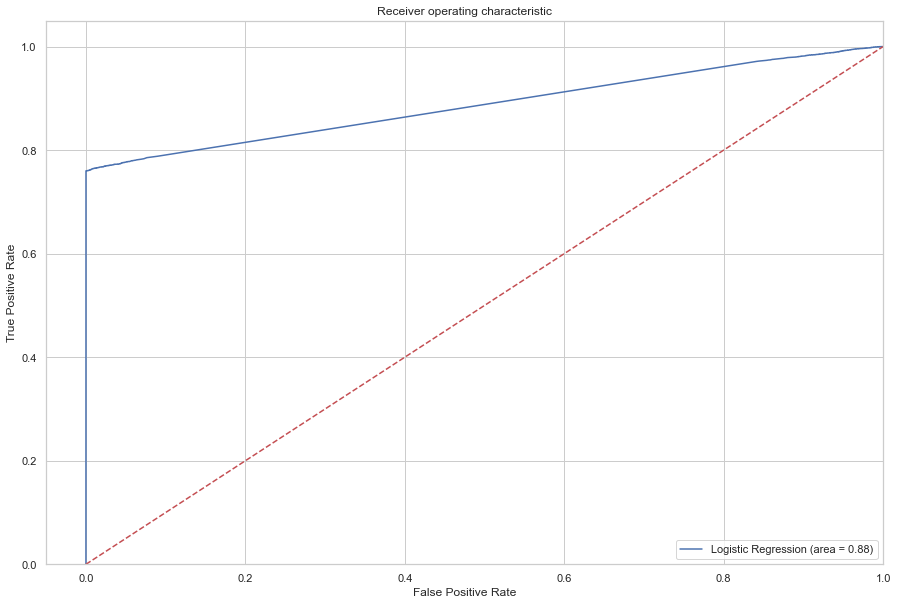

In [419]:
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Compare the models -vizualization

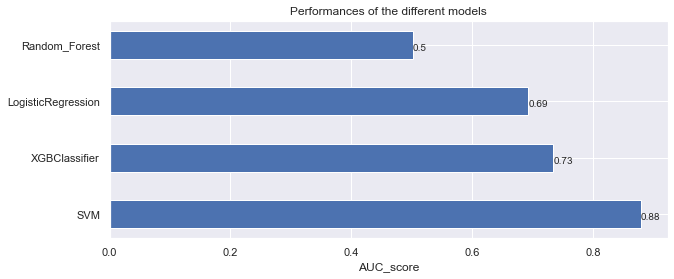

In [324]:
names = ["LogisticRegression", "XGBClassifier", "SVM", "Random_Forest"]
values = [logit_roc_auc_lr, logit_roc_auc_xgb, logit_roc_auc, logit_roc_auc_rand_for]

indices = np.argsort(values)[::-1]

x = []
y = []
for i in indices:
    x.append(values[i])
    y.append(names[i])

fig, ax = plt.subplots(figsize=(10, 4))    
width = 0.50 # the width of the bars 
ind = np.arange(len(x))  # the x locations for the groups
ax.barh(ind, x, width)
ax.set_yticks(ind)
ax.set_yticklabels(y, minor=False)
plt.title('Performances of the different models')
plt.xlabel("AUC_score")
for i, v in enumerate(x):
    ax.text(v, i-.1, str(round(v,2)))

plt.show()

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

Text(0, 0.5, 'True Positive Rate')

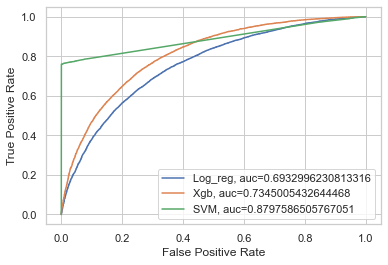

In [420]:
# from sklearn import metrics
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(0).clf()

# ROC curve of the logistic regression model
fpr, tpr, thresh = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.plot(fpr,tpr,label="Log_reg, auc="+str(logit_roc_auc_lr))

# ROC curve of the XGBoost model
fpr, tpr, thresh = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])

plt.plot(fpr,tpr,label="Xgb, auc="+str(logit_roc_auc_xgb))

# ROC curve of the SVM model 
fpr, tpr, thresh = roc_curve(y_test, model_svc.predict_proba(X_test)[:,1])

plt.plot(fpr,tpr,label="SVM, auc="+str(logit_roc_auc))


plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Bank costs

## Optimizing the False négatives and False positives of the confusion matrix

#### Sensitivity (TP Rate or TPR): Proportion of observed positives that were predicted to be positive TP = TP/ (TP+FN)

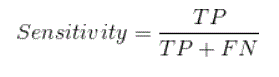

#### Specificity (TN Rate or TNR): Proportion of observed non-defaulted accounts that were correctly predicted as such over the predicted non-defaulted population. Formula: TN = TN/ (TN+FP)

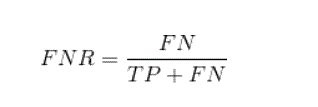


#### Sensitivity and Specificity are the coordinates of the ROC (Receiver Operating Characteristics) graph


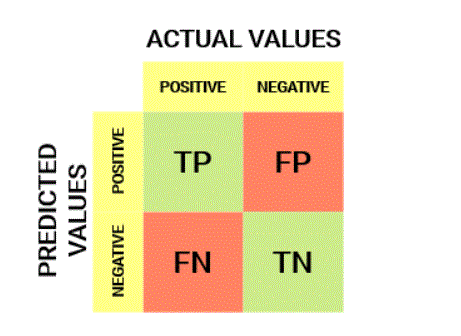

In [145]:

# from sklearn.metrics import confusion_matrix
# confusion_matrix = confusion_matrix(y_test, xgb_y_pred)


# pour calculer le cout bancaire
def cout_bancaire(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    matrice_conf = confusion_matrix(y_true, y_pred)  #la fonction matrice de conf
    cout = matrice_conf[1][0] + 10*matrice_conf[0][1]
    return cout, matrice_conf



In [421]:

# from sklearn.metrics import confusion_matrix
# confusion_matrix = confusion_matrix(y_test, xgb_y_pred)


# pour calculer le cout bancaire
def cout_bancaire(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    matrice_conf = confusion_matrix(y_true, y_pred)  #la fonction matrice de conf
    cout = matrice_conf[1][0] + 10*matrice_conf[0][1]
    return cout, matrice_conf

In [146]:
# concert xgb_y_pred to numpy series du tio error numpy.ndarray not callabl
series_svm_preds = pd.Series(svc_y_pred) 

In [147]:
#c_bancaire_xgb = cout_bancaire(y_test, seies_xgb_preds)

In [ ]:
#svm_y_pred_proba = model_svc.predict_proba(X_test)

In [422]:
# Optimisation 
list_des_couts = []
list_des_seuils=[]

for i in range(0, 100, 5):
    seuil = i/100
    new_y_pred = (svm_y_pred_proba[:,1] >= seuil).astype('int')
    bank_cost = cout_bancaire(y_test, new_y_pred)  # y_true = les labels de X_test 
    
    list_des_couts.append(bank_cost)
    list_des_seuils.append(seuil)

In [325]:
svm_y_pred_proba =svm_y_pred_proba

In [423]:

Bank_charges= []
for i in range (len(list_des_couts)):
    bank_charge =list_des_couts[i][0]
    Bank_charges.append(bank_charge)

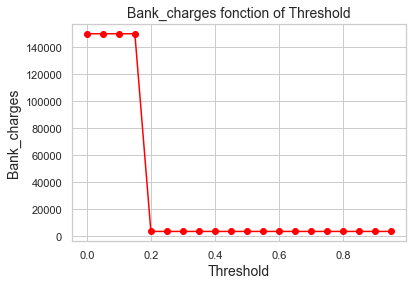

In [424]:
import matplotlib.pyplot as plt
   
Threshold= list_des_seuils
Bank_charges = Bank_charges
  
plt.plot(Threshold, Bank_charges, color='red', marker='o')
plt.title('Bank_charges fonction of Threshold', fontsize=14)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Bank_charges', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# Save all the outputs of SVC
a = numpy.asarray(tpr)
numpy.savetxt("RF_proba_preds.csv", a, delimiter=",")

#### Global Interpretability for SVC model by feature importance calculation

In [288]:
x_test=X_test.iloc[0:1000]
y_y_test = y_test[0:1000]

In [327]:
x_train=X_train.loc[0:3000]
y_y_train = y_train.loc[0:3000]

Text(0.5, 0, 'Permutation Importance')

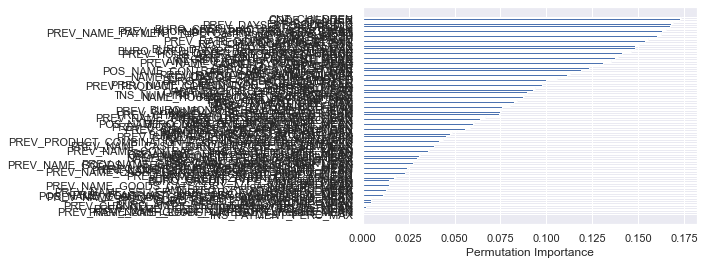

In [326]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



perm_importance = permutation_importance(model_svc, x_test, y_y_test)

feature_names = X_train.columns
features = np.array(X_test.columns)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


In [331]:
#perm_importance.importances_mean

array([0.1722, 0.1724, 0.1504, 0.1554, 0.1734, 0.0046, 0.1286, 0.1372,
       0.1602, 0.106 , 0.1482, 0.1624, 0.1232, 0.1406, 0.0388, 0.1536,
       0.1626, 0.0824, 0.1526, 0.1674, 0.1686, 0.1112, 0.0988, 0.1458,
       0.0406, 0.0132, 0.067 , 0.0926, 0.1352, 0.0484, 0.0756, 0.1076,
       0.0874, 0.0298, 0.0438, 0.0314, 0.018 , 0.0894, 0.1306, 0.123 ,
       0.0046, 0.023 , 0.1482, 0.0604, 0.039 , 0.0476, 0.0038, 0.0248,
       0.0996, 0.0514, 0.0754, 0.1666, 0.0306, 0.1478, 0.0146, 0.0172,
       0.082 , 0.1184, 0.0586, 0.064 , 0.0276, 0.0298, 0.141 , 0.1652,
       0.155 , 0.113 , 0.1678, 0.088 , 0.1388, 0.0868, 0.0116, 0.0004,
       0.0274, 0.0388, 0.0232, 0.036 , 0.1624, 0.059 , 0.0452, 0.0244,
       0.0048, 0.032 , 0.0184, 0.0668, 0.135 , 0.0978, 0.0142, 0.0262,
       0.0054, 0.0008, 0.0558, 0.0016, 0.074 , 0.0752, 0.0118, 0.0242,
       0.0008, 0.0974, 0.0418, 0.0126, 0.0016, 0.119 , 0.011 , 0.0602,
       0.0882, 0.0146, 0.0132, 0.0146, 0.0802, 0.0938, 0.094 , 0.    ,
      

In [340]:
# sorted_idx = perm_importance.importances_mean.argsort()
# sorted_idx

array([111,  71,  89,  96, 100,  91,  46,   5,  40,  80,  88, 102,  70,
        94,  99,  25, 106,  86, 105, 107,  54,  55,  36,  82,  41,  74,
        95,  79,  47,  87,  72,  60,  61,  33,  52,  35,  81, 113,  75,
        14,  73,  44,  24,  98,  34, 115,  78,  45,  29,  49,  90,  58,
        77, 103,  43, 114,  59,  83,  26,  92, 116,  93,  50,  30, 108,
        56,  17, 112,  69,  32,  67, 104,  37,  27, 109, 110,  97,  85,
        22,  48,   9,  31,  21,  65,  57, 101,  39,  12,   6,  38,  84,
        28,   7,  68,  13,  62,  23,  53,  42,  10,   2,  18,  15,  64,
         3,   8,  11,  76,  16,  63,  51,  19,  66,  20,   0,   1,   4],
      dtype=int64)

Text(0, 0.5, 'feature names')

<Figure size 432x288 with 0 Axes>

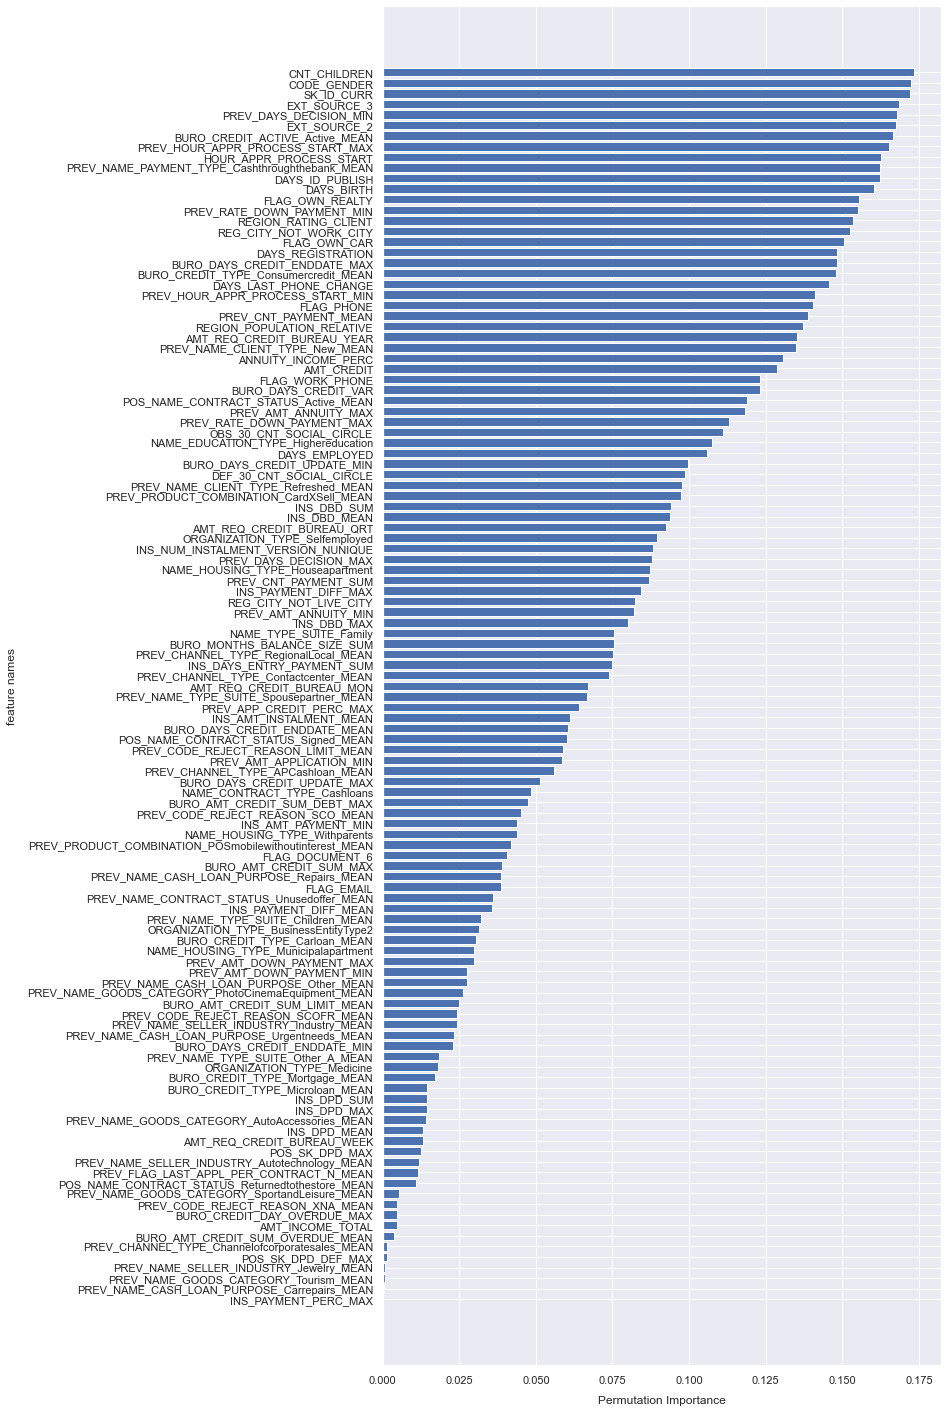

In [349]:
fig = plt.figure()
plt.figure(figsize = [10, 25])
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance", labelpad= 10)
plt.ylabel("feature names",labelpad= 10)

#### Local interpretability for SVC model with LIME - Local Interpretable Model-Agnostic Explanations

In [351]:
x_test = X_test.iloc[0:1000]
y_y_test = y_test[0:1000]
x_train=X_train.iloc[0:3000]
y_y_train=y_train[0:3000]

In [353]:
svc_y_pred = svc_joblib_model.predict(x_test)

In [354]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report, confusion_matrix

print("Test  Accuracy : %.2f"%svc_joblib_model.score(x_test, y_y_test))
print("Train Accuracy : %.2f"%svc_joblib_model.score(x_train, y_y_train))
print()
print("Confusion Matrix : ")
print(confusion_matrix(y_y_test, svc_y_pred))
print()
print("Classification Report")
print(classification_report(y_y_test, svc_y_pred))

Test  Accuracy : 0.87
Train Accuracy : 1.00

Confusion Matrix : 
[[515   0]
 [134 351]]

Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       515
           1       1.00      0.72      0.84       485

    accuracy                           0.87      1000
   macro avg       0.90      0.86      0.86      1000
weighted avg       0.89      0.87      0.86      1000



In [357]:
pip install lime

  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=527aafdb6755975e32dd0e7bf9b8852a78c4b23fee82a2d7b74b3646b360902c
  Stored in directory: c:\users\adele\appdata\local\pip\cache\wheels\ed\d7\c9\5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [381]:
import lime
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(training_data =X_train.values,
                                              feature_names=X_train.columns.values,
                                              class_names =['Non_defaulter_0','Defaulter_1'],
                                              mode="classification",
                                             verbose=True,
                                             random_state=10)

explainer

In [398]:
x_test_array = X_test.iloc[3]

In [399]:
num=1
test_sample=x_test.iloc[num,:]

In [400]:
lim_exp =explainer.explain_instance(data_row=test_sample,
                                   predict_fn=svc_joblib_model.predict_proba,
                                    num_features=20)

C:\Users\adele\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Intercept 0.16608315240871202
Prediction_local [0.19752036]
Right: 0.9999998975247016


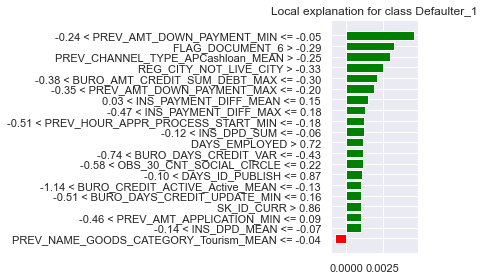

In [401]:
# Plotting the results 

plt=lim_exp.as_pyplot_figure()
plt.tight_layout()

    Correlations= to the label 0 are explained in RED
    Correlations= to the label 1  are explained in GREEN
    So we see which are the features that contribute for this test sample for becoming a part of  defaulter(=1) or non defaulter(=0)

### Next , lets export the coefficients to understand each feature's contribution to the output

In [386]:
coefs = pd.DataFrame(lim_exp.as_list())[1].sum() # ensure coefs for all features
print('Sum of coefficients and intercept=', coefs+0.17)
pd.DataFrame(lim_exp.as_list())


Sum of coefficients and intercept= 0.2007517722694479


,0,1
0,-0.24 < PREV_AMT_DOWN_PAYMENT_MIN <= -0.05,0.004679
1,FLAG_DOCUMENT_6 > -0.29,0.003293
2,PREV_CHANNEL_TYPE_APCashloan_MEAN > -0.25,0.002973
3,REG_CITY_NOT_LIVE_CITY > -0.33,0.002112
4,-0.38 < BURO_AMT_CREDIT_SUM_DEBT_MAX <= -0.30,0.001998
5,-0.35 < PREV_AMT_DOWN_PAYMENT_MAX <= -0.20,0.001952
6,0.03 < INS_PAYMENT_DIFF_MEAN <= 0.15,0.001414
7,-0.47 < INS_PAYMENT_DIFF_MAX <= 0.18,0.001249
8,-0.74 < BURO_DAYS_CREDIT_VAR <= -0.43,0.001236
9,-0.12 < INS_DPD_SUM <= -0.06,0.001138


intercept= 0.2007517722694479 is the probability for this test sample to be part of the category/ class 0
and 1 -0.2007517722694479  is th eprobability for this test_sample to be part of the category / class 1

In [402]:
lim_exp.show_in_notebook(show_table=True, show_all=False)

### XGBoost model Bank costs caluculation

In [221]:
series_xgb_preds = xgb_model.predict_proba(X_test)

In [217]:
c_bancaire_xgb = cout_bancaire(y_test, series_xgb_preds)

In [231]:
list_des_couts_xgb = []
list_des_seuils_xgb=[]

for i in range(0, 100, 5):
    seuil = i/100
    new_y_pred_xgb = (series_xgb_preds[:,1] >= seuil).astype('int')
    bank_cost_xgb = cout_bancaire(y_test, new_y_pred_xgb)  # y_true = les labels de X_test 
    
    list_des_couts_xgb.append(bank_cost_xgb)
    list_des_seuils_xgb.append(seuil)

In [232]:
Bank_charges_xgb= []
for i in range (len(list_des_couts_xgb)):
    bank_charge =list_des_couts_xgb[i][0]
    Bank_charges_xgb.append(bank_charge)

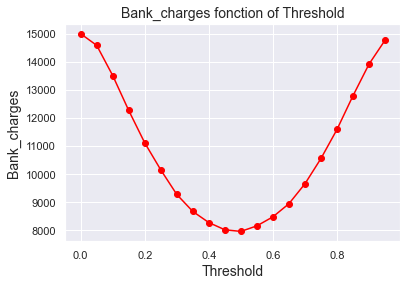

In [233]:
import matplotlib.pyplot as plt
   
Threshold= list_des_seuils_xgb
Bank_charges = Bank_charges_xgb
  
plt.plot(Threshold, Bank_charges, color='red', marker='o')
plt.title('Bank_charges fonction of Threshold', fontsize=14)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Bank_charges', fontsize=14)
plt.grid(True)
plt.show()

In [280]:
#xgb_model.feature_importances_

array([0.00453922, 0.02677171, 0.01305691, 0.00379805, 0.00601899,
       0.00605343, 0.01000061, 0.00586711, 0.01216806, 0.01195939,
       0.00640065, 0.00843689, 0.00693015, 0.00823132, 0.00833502,
       0.01117133, 0.0047568 , 0.01831647, 0.00809641, 0.04987416,
       0.03870882, 0.00513063, 0.01135308, 0.00755659, 0.        ,
       0.        , 0.0123953 , 0.01739628, 0.00633403, 0.01388033,
       0.00429353, 0.03563263, 0.00643948, 0.00892683, 0.00398418,
       0.00298364, 0.00621594, 0.00811061, 0.00623105, 0.00696238,
       0.        , 0.00542791, 0.00904988, 0.00848315, 0.00605231,
       0.00581977, 0.00809356, 0.00704157, 0.01682523, 0.00570231,
       0.01858249, 0.00728124, 0.00764783, 0.00670566, 0.01292759,
       0.00917739, 0.00720466, 0.0060544 , 0.00561535, 0.006917  ,
       0.00477678, 0.01329222, 0.00580716, 0.00574097, 0.00591274,
       0.0068267 , 0.0075193 , 0.00748739, 0.00978993, 0.0066325 ,
       0.00401382, 0.        , 0.00696709, 0.00552263, 0.00622

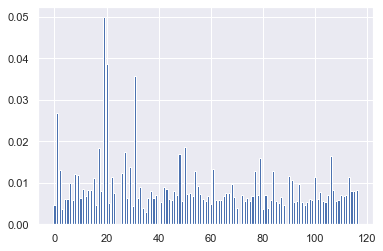

In [282]:
# from matplotlib import pyplot
# # plot
# pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
# pyplot.show()

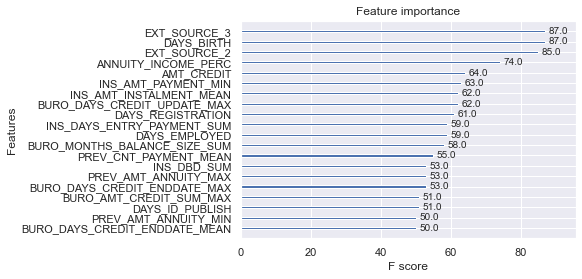

In [284]:
# from xgboost import plot_importance
# #plot feature importance
# plot_importance(xgb_model, max_num_features=20)
# pyplot.show()

In [49]:
# API 
# Fast API 

Entrainement des différents models avec gridsearchcv
Trouver le seuil optimal avec le cout bancaire sur le meilleur modèle
Faire l'interprétabilté 
global avec feature importance https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#:~:text=Feature%20importances%20are%20provided%20by,impurity%20decrease%20within%20each%20tree.&text=Impurity%2Dbased%20feature%20importances%20can,features%20(many%20unique%20values).
individuellle avec lime.  https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions
sauvegarder le meilleur model avec joblib
Déploiement modele sous forme d'api
L'api prend en entrée l'indice d'un client retourne la classe et la probabilité  https://towardsdatascience.com/how-to-deploy-machine-learning-models-as-a-microservice-using-fastapi-b3a6002768af
Déploiement du modele sur heroku 
https://www.tutlinks.com/create-and-deploy-fastapi-app-to-heroku/
Faire le dashboard avec streamlit https://streamlit.io/
avoir un menu pour selection l'index d'un client
Afficher client avec st.dataframe
envoyer l'index à l'api puis afficher le résultat
Afficher l'interprétabilité individuelle du client
Distribution de quelques variables en mettant en exergue le client avec possibilté de selection une à une
Déploiement du dashboard avec streamlit share

## Further improving the classificationt with Neaural Networks training

In [209]:

from keras.models import Sequential
from keras.layers import Dense
 
model = Sequential() 
model.add(Dense(512, activation='relu', input_dim=117))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               60416     
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 60,929
Trainable params: 60,929
Non-trainable params: 0
_________________________________________________________________


In [211]:
	
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100)


Epoch 1/30
700/700 [==============================] - 2s 2ms/step - loss: 0.4370 - accuracy: 0.7973 - val_loss: 0.5668 - val_accuracy: 0.7348
Epoch 2/30
700/700 [==============================] - 2s 2ms/step - loss: 0.4265 - accuracy: 0.8063 - val_loss: 0.5691 - val_accuracy: 0.7280
Epoch 3/30
700/700 [==============================] - 2s 2ms/step - loss: 0.4090 - accuracy: 0.8155 - val_loss: 0.5721 - val_accuracy: 0.7322
Epoch 4/30
700/700 [==============================] - 1s 2ms/step - loss: 0.3989 - accuracy: 0.8229 - val_loss: 0.5638 - val_accuracy: 0.7416
Epoch 5/30
700/700 [==============================] - 1s 2ms/step - loss: 0.3812 - accuracy: 0.8327 - val_loss: 0.5653 - val_accuracy: 0.7457
Epoch 6/30
700/700 [==============================] - 1s 2ms/step - loss: 0.3672 - accuracy: 0.8411 - val_loss: 0.5648 - val_accuracy: 0.7515
Epoch 7/30
700/700 [==============================] - 1s 2ms/step - loss: 0.3550 - accuracy: 0.8471 - val_loss: 0.5817 - val_accuracy: 0.7405
Epoch 

[]

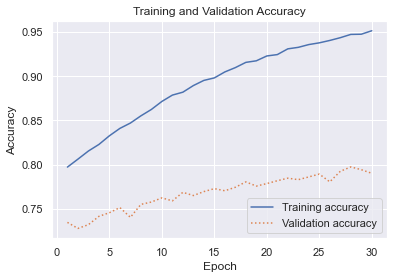

In [212]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
 
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

938/938 [==============================] - 1s 981us/step


Text(89.133125, 0.5, 'Actual label')

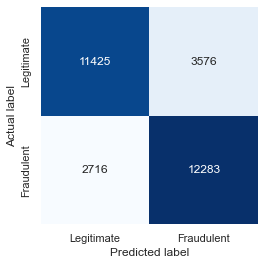

In [214]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model.predict(X_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Legitimate', 'Fraudulent']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')